In [1]:
# runup with variable slope
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

data_dir = 'D:/crs/proj/2022_runup/'
fnames = ['hom_profiles.csv']

# from colorbrewer
oranges = ['#ffffd4','#fee391','#fec44f','#fe9929','#d95f0e','#993404']
blues =   ['#eff3ff','#c6dbef','#9ecae1','#6baed6','#3182bd','#08519c']

In [2]:
def calc_L0(Tp = 10.):
    # deepwater wavelength from peak period
    L0 = (9.81*Tp**2)/(2.*np.pi)
    return L0

def S06(H0 = 2., L0 = 156.131, Beta = 0.02):
    # r2% runup from Stockdon et al., 2006
    Ir = Beta/np.sqrt(H0/L0)
    S06_Setup = 0.35*Beta*np.sqrt(H0*L0)
    S06_Sinc = 0.75*Beta*np.sqrt(H0*L0)
    S06_Sig = 0.06*np.sqrt(H0*L0)
    S = np.sqrt(S06_Sinc**2+S06_Sig**2)
    R2 = 1.1*(S06_Setup+0.5*S)
    return R2


def vslope_R2( H0, L0, fixslope, wl, elev, iverbose=False, maxit = 10):
    # iterate - calcuate runup, find slope in that elevation range, re-calc runup...
    
    # initialize arrays
    slope = np.nan*np.ones(maxit+1)
    R2 = np.ones_like( slope )
    eR2 = np.ones_like( slope )
    dR2 = np.ones_like( slope )

    fixslopeR2 = S06( Hs, L0, fixslope )

    if iverbose:
        print( 'iter   Slope    Runup   Elev   Change')
    # first guess
    slope[0] = fixslope
    # distance to MWL
    dwl = dist[ np.argwhere( elev <= 0.)[0] ]
    for i in range(maxit):
        R2[i] = S06( Hs, L0, slope[i] )
        eR2[i] = R2[i]+wl
        iR2 = np.argwhere( elev <= eR2[i])[0]
        dR2[i] = dist[iR2]
        iwl = np.argwhere( elev <= wl)[0]
        slope[i+1] = (eR2[i] - 0.)/(dwl - dR2[i])
        del_R2 = np.nan
        if i > 0:
            del_R2 = eR2[i]-eR2[i-1]
        if iverbose:
            print('{} {:.3f}    {:.2f}    {:.2f}   {}'.format(i, slope[i], R2[i], eR2[i], del_R2))

    if np.abs( del_R2 ) <= 0.01:
        converged = True
        finalR2 = R2[i]
        final_slope = slope[i]
        if iverbose:
            print('Converged: r2 = {:.3f}'.format(finalR2))
    else:
        converged = False
        finalR2 = (R2[i]+R2[i-1])/2.
        final_slope = (slope[i]+slope[i-1])/2.

        if iverbose:
            print('Not converged: r2 = {:.3f}'.format(finalR2))

    return fixslopeR2, finalR2, final_slope, converged

In [3]:
# load a profile
fname = fnames[0]
df=pd.read_csv(data_dir+fname,header = 0,delimiter=',')
df

,ID,X,Y,Elevation,Elevation (2020015FA_Truro_topobathy_1m.tif),Elevation (2021014FA_Truro_topobathy_1m.tif),Elevation (2022015FA_Truro_Topobathy_1m.tif),Distance (Segment),Distance (Total),Distance 3D (Segment),Distance 3D (Total),Slope (Degrees),Slope (Percent),Segment Index
0,1,410754.987,4656015.953,16.989,16.850,16.674,16.989,0.000,0.000,0.000,0.000,0.0,0.0,1
1,2,410755.424,4656016.639,16.946,16.895,16.687,16.946,0.813,0.813,0.814,0.814,3.0,5.2,1
2,3,410755.860,4656017.324,16.854,16.922,16.679,16.854,0.813,1.626,0.818,1.632,6.5,11.4,1
3,4,410756.297,4656018.009,16.783,16.929,16.644,16.783,0.813,2.438,0.816,2.448,5.0,8.7,1
4,5,410756.733,4656018.695,16.764,16.903,16.563,16.764,0.813,3.251,0.813,3.261,1.4,2.4,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1019,1020,411199.746,4656714.365,-9.275,NaN,-9.453,-9.275,0.813,828.250,0.813,831.670,1.5,2.5,1
1020,1021,411200.182,4656715.051,-9.295,NaN,-9.470,-9.295,0.813,829.070,0.813,832.480,1.4,2.5,1
1021,1022,411200.619,4656715.736,-9.316,NaN,-9.487,-9.316,0.813,829.880,0.813,833.300,1.4,2.5,1
1022,1023,411201.055,4656716.422,-9.336,NaN,-9.505,-9.336,0.813,830.690,0.813,834.110,1.4,2.5,1


In [4]:
# extract data columns with convenient names
dist = df['Distance (Total)'].values
e2020 = df['Elevation (2020015FA_Truro_topobathy_1m.tif)'].values
e2021 = df['Elevation (2021014FA_Truro_topobathy_1m.tif)'].values
e2022 = df['Elevation (2022015FA_Truro_Topobathy_1m.tif)'].values

In [5]:
# mean slope
x1 = 80
e20 = e2020[np.argwhere(dist>=x1)[0]] 
x20 = dist[np.argwhere(dist>=0)[0]]
s20 = e20/(x1-x20)
print(s20)
e21 = e2021[np.argwhere(dist>=x1)[0]] 
x21 = dist[np.argwhere(dist>=0)[0]]
s21 = e21/(x1-x21)
print(s21)
e22 = e2022[np.argwhere(dist>=x1)[0]] 
x22 = dist[np.argwhere(dist>=0)[0]]
s22 = e22/(x1-x22)
print(s22)

[0.0375375]
[0.0441375]
[0.0470125]


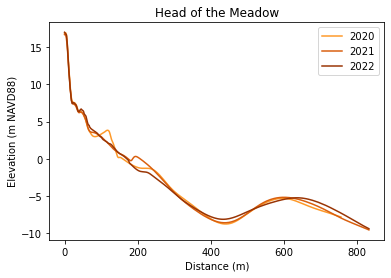

In [6]:
# plot the profiles
plt.plot(dist, e2020, label='2020', c = oranges[3])
plt.plot(dist, e2021, label='2021', c = oranges[4])
plt.plot(dist, e2022, label='2022', c = oranges[5])
plt.ylabel('Elevation (m NAVD88)')
plt.xlabel('Distance (m)')
plt.title('Head of the Meadow')
_ = plt.legend()
#plt.savefig(data_dir+'hom_runup_profile.jpg', dpi=200, bbox_inches='tight')

[225.15] [81.281] 0.013901535424587646
[591.73] [458.42] 0.015002625459455405


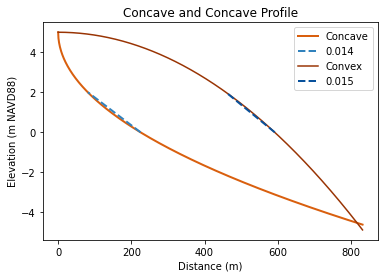

In [7]:
# make fake concave profile
econcave = -np.sqrt(dist)/3 + 5
# make fake convex profile
econvex = -dist**2 / 70000. +5.

# calc nominal slopes between 0 and 2 m
# concave
d0v = dist[np.argwhere(econcave<=0)[0]]
d2v = dist[np.argwhere(econcave<=2)[0]]
sv = np.squeeze( 2./(d0v-d2v) )
print(d0v,d2v,sv)
# convex
d0x = dist[np.argwhere(econvex<=0)[0]]
d2x = dist[np.argwhere(econvex<=2)[0]]
sx = np.squeeze( 2./(d0x-d2x) )
print(d0x,d2x,sx)

plt.plot(dist, econcave, linewidth=2, c = oranges[4], label='Concave')
plt.plot([d0v, d2v],[0, 2],'--', linewidth=2, c=blues[4], label = '{:.3f}'.format(sv) )
plt.plot(dist, econvex, c = oranges[5], label='Convex')
plt.plot([d0x, d2x],[0, 2],'--', linewidth=2, c=blues[5], label = '{:.3f}'.format(sx) )
plt.ylabel('Elevation (m NAVD88)')
plt.xlabel('Distance (m)')
plt.legend()
_ = plt.title('Concave and Concave Profile')

9
0.5491648599258133 0.5355664977993433 0.011765520611997813 True
0.5491648599258133 0.5377620056305652 0.012113824475500457 True
0.5491648599258133 0.5396905540192014 0.012418664047045202 True
0.5491648599258133 0.5422470788507887 0.012821183439329033 True
0.5491648599258133 0.5446405390088044 0.01319641639477443 True
0.5491648599258133 0.546989696315873 0.01356321002578259 True
0.5491648599258133 0.5498686318213774 0.014010735178913979 True
0.5491648599258133 0.5527355363500307 0.014454250378816442 True
0.5491648599258133 0.5561193802157587 0.014975039136079771 True
0.5562991475214814 0.566815820748393 0.01660268967874665 True
0.5562991475214814 0.5638018947016377 0.01614686299853188 True
0.5562991475214814 0.5624429637212006 0.015940629614060092 True
0.5562991475214814 0.561650597373638 0.01582017365053604 True
0.5562991475214814 0.5593619483745451 0.015471395459642675 True
0.5562991475214814 0.5578084098686324 0.015233912613706175 True
0.5562991475214814 0.5560695028049399 0.014967

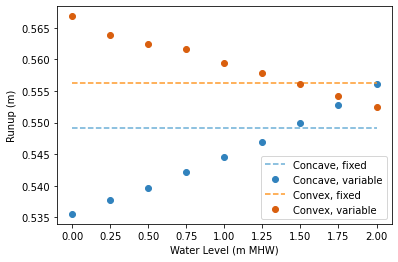

In [8]:
# list of the available profiles
prof_list = [econvex, econcave, e2020, e2021, e2022]
prof_list = [econvex, econcave]

# list of starting water levels
wl_list = np.arange(0., 2.25, .25)
#wl_list = [1.]
nwl = len(wl_list)
print(nwl)

Hs = 2.
Tp = 8.
L0 = calc_L0( Tp )

maxit = 7

rv = np.nan*np.ones(nwl)
rx = np.nan*np.ones(nwl)

elev = econcave
fixslope = sv
for iw, wl in enumerate( wl_list ):
    fixslopeR2, finalR2, del_R2, converged = vslope_R2( Hs, L0, fixslope, wl, elev, iverbose=False )
    rv[iw]=finalR2 
    print(fixslopeR2, finalR2, del_R2, converged )
    fvR2 = fixslopeR2*np.ones_like(rv)

    
elev = econvex
fixslope = sx
for iw, wl in enumerate( wl_list ):
    fixslopeR2, finalR2, final_slope, converged = vslope_R2( Hs, L0, fixslope, wl, elev, iverbose=False )
    rx[iw]=finalR2 
    print(fixslopeR2, finalR2, final_slope, converged )
    fxR2 = fixslopeR2*np.ones_like(rv)

plt.plot(wl_list, fvR2, '--', c=blues[3], label='Concave, fixed')
plt.plot(wl_list, rv,'o', c=blues[4], label='Concave, variable')
plt.plot(wl_list, fxR2, '--', c=oranges[3], label='Convex, fixed')
plt.plot(wl_list, rx,'o', c=oranges[4], label='Convex, variable')
plt.xlabel('Water Level (m MHW)')
plt.ylabel('Runup (m)')
_= plt.legend()


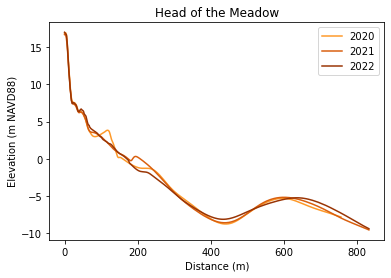

In [9]:
# plot
plt.plot(dist, e2020, label='2020', c = oranges[3])
plt.plot(dist, e2021, label='2021', c = oranges[4])
plt.plot(dist, e2022, label='2022', c = oranges[5])
plt.ylabel('Elevation (m NAVD88)')
plt.xlabel('Distance (m)')
plt.title('Head of the Meadow')
_ = plt.legend()
#plt.savefig(data_dir+'hom_runup_profile.jpg', dpi=200, bbox_inches='tight')